In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# **Load Data Set**

In [34]:
# Load the data
df = pd.read_csv('../Data/data_5KNN.csv')

#### Select the only 12 most important variables identified by Lasso

In [35]:
top12_variables = ["y", "x_32", "x_62","x_36", "x_57","x_10", "x_30", "x_41","x_45", "x_29","x_54", "x_76", "x_64"]
df_12 = df[top12_variables]

data = df_12.to_numpy()

In [36]:
# Get the variables
X = data[:,1:]
y = data[:,0]

# Shape
[n, p] = np.shape(X)

# **OLS**

## **Training**

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Initialize scaler (standardization)
scaler = StandardScaler()

ols_model = LinearRegression()
ols_model.fit(X, y)

LinearRegression()

## $\boldsymbol{\hat{RMSE}}$

In [38]:
from sklearn.model_selection import cross_val_score
# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_ols = np.sqrt(-cross_val_score(ols_model, scaler.fit_transform(X), y, scoring='neg_mean_squared_error', cv=5))

# Estimate of RMSE (average over folds)
estimated_RMSE_ols = np.mean(cv_rmse_scores_ols)

print(f"Estimated RMSE for each fold OLS: {cv_rmse_scores_ols}")
print(f"Estimated RMSE (average) OLS: {estimated_RMSE_ols:.4f}")

Estimated RMSE for each fold OLS: [25.3411938  18.56301145 30.92576397 30.16678905 23.17078617]
Estimated RMSE (average) OLS: 25.6335


# **Ridge Regression**

In [39]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## **Training**

In [40]:
# Define a range of lambda (alpha) values to test
lambda_values = np.logspace(-3, 3, 100)

# Initialize scaler (standardization)
scaler = StandardScaler()

# Define a pipeline that includes normalization and regression to indtroduce in the GridSearchCV
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('ridge', Ridge())             # Apply Ridge Regression
])

# We need a dictionary as an input for the parameters
param_lambda_values = {'ridge__alpha' : lambda_values}

# Perform GridSearchCV to find the best lambda (alpha in this case)
# Its basically a tool to tune/optimize a hyperparamter (lambda in this case)
# its neg_mse beacuse we want to MINIMIZE the score mse (gridsearch always maximizes the score)
ridge_cv = GridSearchCV(estimator=ridge_pipeline, param_grid=param_lambda_values, scoring='neg_mean_squared_error', cv=5) # we obtain min RMSE with 5 folds
ridge_cv.fit(X, y)  # it is using the normalized data stablished in the pipeline

# Get the best lambda
best_lambda_ridge = ridge_cv.best_params_['ridge__alpha']
print(f"Best lambda for Ridge: {best_lambda_ridge}")

# Fit Ridge with the BEST lambda
best_ridge = Ridge(alpha=best_lambda_ridge)
best_ridge.fit(scaler.fit_transform(X), y)  # Transform X_train before fitting

Best lambda for Ridge: 2.1544346900318843


Ridge(alpha=np.float64(2.1544346900318843))

In [41]:
# Define a range of lambda (alpha) values to test
lambda_values = np.logspace(-3, 3, 100)

# Initialize scaler (standardization)
scaler = StandardScaler()

# Define a pipeline that includes normalization and regression to indtroduce in the GridSearchCV
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('ridge', Ridge())             # Apply Ridge Regression
])

# We need a dictionary as an input for the parameters
param_lambda_values = {'ridge__alpha' : lambda_values}

# Perform GridSearchCV to find the best lambda (alpha in this case)
# Its basically a tool to tune/optimize a hyperparamter (lambda in this case)
# its neg_mse beacuse we want to MINIMIZE the score mse (gridsearch always maximizes the score)
ridge_cv = GridSearchCV(estimator=ridge_pipeline, param_grid=param_lambda_values, scoring='neg_mean_squared_error', cv=5) # we obtain min RMSE with 5 folds
ridge_cv.fit(X, y)  # it is using the normalized data stablished in the pipeline

# Get the best lambda
best_lambda_ridge = ridge_cv.best_params_['ridge__alpha']
# print(f"Best lambda for Ridge: {best_lambda_ridge}")

# Apply one standard error rule
cv_results = ridge_cv.cv_results_
mean_scores = -cv_results['mean_test_score']  # Convert back to MSE
std_scores = cv_results['std_test_score']

# # Way 1: Class
# maxAcc = np.argsort(mean_scores)[0]
# J = np.where(mean_scores[maxAcc] + std_scores[maxAcc] > mean_scores)[0]

# if len(J) > 0:
#     best_lambda_ose = lambda_values[int(J[-1])]
# else:
#     best_lambda_ose = best_lambda_ridge

# Way 2: sklearn
best_idx = ridge_cv.best_index_     # find the indx with the lowest mse
one_std_error = mean_scores[best_idx] + std_scores[best_idx]

# Find the simplest model (largest lambda) within one std error
candidate_indices = np.where(mean_scores <= one_std_error)[0]
best_lambda_ridge_ose = np.max(lambda_values[candidate_indices])

# Parameters
print(f"Best lambda (original): {ridge_cv.best_params_['ridge__alpha']:.4f}")
print(f"Best lambda (one std error): {best_lambda_ridge_ose:.4f}")

# Fit Ridge with the one std error lambda
best_ridge = Ridge(alpha=best_lambda_ridge_ose)
best_ridge.fit(scaler.fit_transform(X), y)

Best lambda (original): 2.1544
Best lambda (one std error): 17.4753


Ridge(alpha=np.float64(17.47528400007683))

## $\boldsymbol{\hat{RMSE}}$

For now, just trying with Kfold CV. Later on we'll try bootstrap etc 

In [42]:
from sklearn.model_selection import cross_val_score

# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_ridge = np.sqrt(-cross_val_score(best_ridge, scaler.transform(X), y, scoring='neg_mean_squared_error', cv=5))

# Estimate of RMSE (average over folds)
estimated_RMSE_ridge = np.mean(cv_rmse_scores_ridge)

print(f"Estimated RMSE for each fold Ridge Regression: {cv_rmse_scores_ridge}")
print(f"Estimated RMSE (average) Ridge Regression: {estimated_RMSE_ridge:.4f}")

Estimated RMSE for each fold Ridge Regression: [27.1431903  21.41209378 34.47916521 36.4939952  24.6999931 ]
Estimated RMSE (average) Ridge Regression: 28.8457


## **Plots**

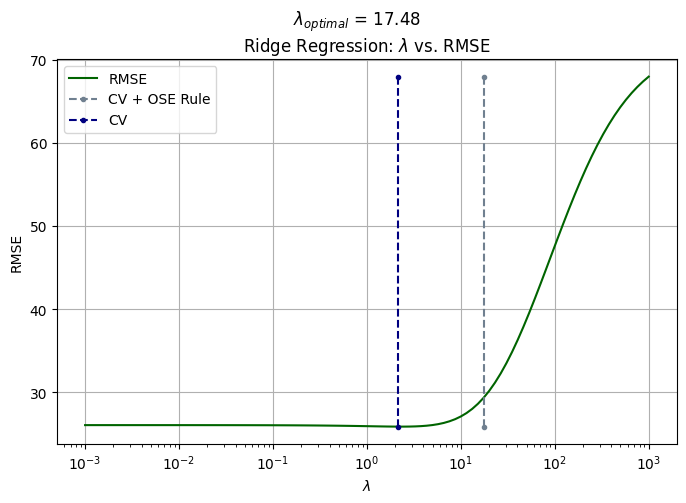

In [43]:
mse_scores = -ridge_cv.cv_results_['mean_test_score']
rmse_scores = np.sqrt(mse_scores)

plt.figure(figsize=(8, 5))
plt.plot(lambda_values, rmse_scores, color='darkgreen', linestyle='-', label='RMSE')
plt.semilogx([best_lambda_ridge_ose, best_lambda_ridge_ose], [np.min(rmse_scores), np.max(rmse_scores)], marker = ".", linestyle = '--', color='slategray', label='CV + OSE Rule')
plt.semilogx([best_lambda_ridge, best_lambda_ridge], [np.min(rmse_scores), np.max(rmse_scores)], marker = ".", linestyle = '--', color='navy', label='CV')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel(r"$\lambda$")
plt.ylabel("RMSE")
plt.suptitle(rf"$\lambda_{{optimal}}$ = {best_lambda_ridge_ose:.2f}", fontsize=12)
plt.title(r"Ridge Regression: $\lambda$ vs. RMSE")
plt.legend()
plt.grid()
plt.show()

# **Lasso Regression**

In [44]:
from sklearn.linear_model import Lasso

## **Training: Cyclical Coordinate Descent**

In [45]:
# Define a range of lambda (alpha) values to test
lambda_values = np.logspace(-3, 3, 100)

# Initialize scaler (standardization)
scaler = StandardScaler()

# Define a pipeline that includes normalization and regression to indtroduce in the GridSearchCV
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('lasso', Lasso(max_iter=50000))             # Apply Lasso Regression
])

# We need a dictionary as an input for the parameters
param_lambda_values = {'lasso__alpha' : lambda_values}

# Perform GridSearchCV to find the best lambda (alpha in this case)
# Its basically a tool to tune/optimize a hyperparamter (lambda in this case)
# its neg_mse beacuse we want to MINIMIZE the score mse (gridsearch always maximizes the score)
lasso_cv = GridSearchCV(estimator=lasso_pipeline, param_grid=param_lambda_values, scoring='neg_mean_squared_error', cv=5) # we obtain min RMSE with 5 folds
lasso_cv.fit(X, y)  # it is using the normalized data stablished in the pipeline

# Apply one standard error rule (OSE)
cv_results = lasso_cv.cv_results_
mean_scores = -cv_results['mean_test_score']  # Convert back to MSE
std_scores = cv_results['std_test_score']

best_idx = lasso_cv.best_index_     # find the indx with the lowest mse
one_std_error = mean_scores[best_idx] + std_scores[best_idx]

# Find the simplest model (largest lambda) within one std error
candidate_indices = np.where(mean_scores <= one_std_error)[0]
best_lambda_lasso_ose = np.max(lambda_values[candidate_indices])

# Parameters
print(f"Best lambda Lasso (original): {lasso_cv.best_params_['lasso__alpha']:.4f}")
print(f"Best lambda Lasso (one std error): {best_lambda_lasso_ose:.4f}")

# Fit Ridge with the BEST lambda
best_lasso = Lasso(alpha=best_lambda_lasso_ose)
best_lasso.fit(scaler.fit_transform(X), y)  # Transform X before fitting

Best lambda Lasso (original): 0.2656
Best lambda Lasso (one std error): 4.9770


Lasso(alpha=np.float64(4.9770235643321135))

## $\boldsymbol{\hat{RMSE}}$**: Cyclical Coordinate Descent**

In [46]:
from sklearn.model_selection import cross_val_score
# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_lasso = np.sqrt(-cross_val_score(best_lasso, scaler.transform(X), y, scoring='neg_mean_squared_error', cv=5))

# Estimate of RMSE (average over folds)
estimated_RMSE_lasso = np.mean(cv_rmse_scores_lasso)

print(f"Estimated RMSE for each fold Lasso: {cv_rmse_scores_lasso}")
print(f"Estimated RMSE (average) Lasso: {estimated_RMSE_lasso:.4f}")

Estimated RMSE for each fold Lasso: [28.89467269 18.42456299 33.66203069 38.81285566 26.18053598]
Estimated RMSE (average) Lasso: 29.1949


## **Plot: Cyclical Coordinate Descent**

Let's check which variables are most relevant.

In [47]:
# Lasso model coefficients are:
lasso_coef = best_lasso.coef_
print(f'There are {sum(lasso_coef != 0)} non-zero coefficients out of {len(lasso_coef)}.')

There are 12 non-zero coefficients out of 12.


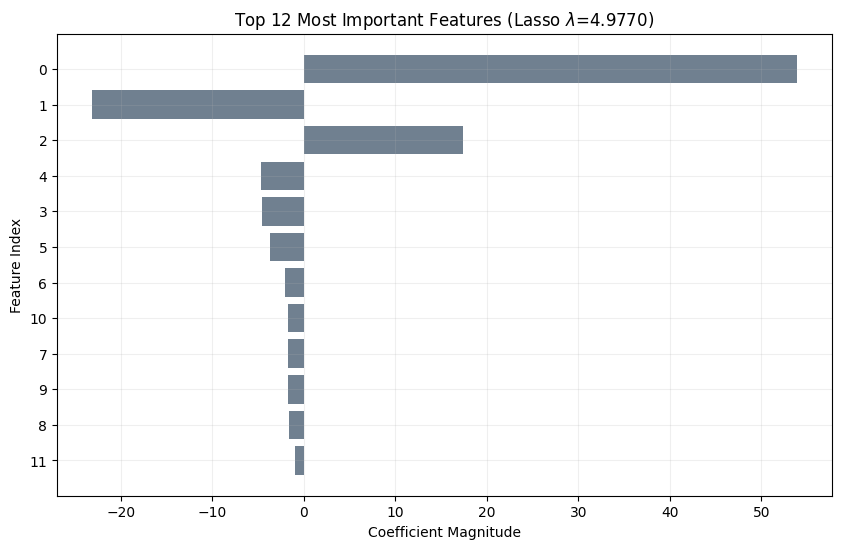

In [48]:
feature_indices = np.arange(X.shape[1])

# Get coefficients and sort by absolute value
sorted_idx = np.argsort(np.abs(lasso_coef))[::-1]
sorted_coefs = lasso_coef[sorted_idx]
sorted_features = feature_indices[sorted_idx]

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.barh(range(sum(lasso_coef != 0)), sorted_coefs[:sum(lasso_coef != 0)], align='center',color='slategray')
plt.yticks(range(sum(lasso_coef != 0)), sorted_features[:sum(lasso_coef != 0)])
plt.title(rf'Top {sum(lasso_coef != 0)} Most Important Features (Lasso $\lambda$={best_lambda_lasso_ose:.4f})')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature Index')
plt.grid(alpha=0.2)
plt.gca().invert_yaxis()  # Highest coefficient at top
plt.show()

#################################################################################################################

In [49]:
from sklearn.linear_model import LassoLars

## **Training: LARS**

In [50]:
# Define a range of lambda (alpha) values to test
lambda_values = np.logspace(-3, 3, 100)

# Initialize scaler (standardization)
scaler = StandardScaler()

# Define a pipeline that includes normalization and regression to indtroduce in the GridSearchCV
lasso_lars_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('lasso_lars', LassoLars())             # Apply Lasso LARS Regression
])

# We need a dictionary as an input for the parameters
param_lambda_values = {'lasso_lars__alpha' : lambda_values}

# Perform GridSearchCV to find the best lambda (alpha in this case)
# Its basically a tool to tune/optimize a hyperparamter (lambda in this case)
# its neg_mse beacuse we want to MINIMIZE the score mse (gridsearch always maximizes the score)
lasso_lars_cv = GridSearchCV(estimator=lasso_lars_pipeline, param_grid=param_lambda_values, scoring='neg_mean_squared_error', cv=5) # we obtain min RMSE with 5 folds
lasso_lars_cv.fit(X, y)  # it is using the normalized data stablished in the pipeline

# Apply one standard error rule (OSE)
cv_results = lasso_lars_cv.cv_results_
mean_scores = -cv_results['mean_test_score']  # Convert back to MSE
std_scores = cv_results['std_test_score']

best_idx = lasso_lars_cv.best_index_     # find the indx with the lowest mse
one_std_error = mean_scores[best_idx] + std_scores[best_idx]

# Find the simplest model (largest lambda) within one std error
candidate_indices = np.where(mean_scores <= one_std_error)[0]
best_lambda_lasso_lars_ose = np.max(lambda_values[candidate_indices])

# Parameters
print(f"Best lambda Lasso LARS (original): {lasso_lars_cv.best_params_['lasso_lars__alpha']:.4f}")
print(f"Best lambda Lasso LARS (one std error): {best_lambda_lasso_lars_ose:.4f}")

# Fit Ridge with the BEST lambda
best_lasso_lars = LassoLars(alpha=best_lambda_lasso_lars_ose)
best_lasso_lars.fit(scaler.fit_transform(X), y)  # Transform X before fitting

Best lambda Lasso LARS (original): 0.3054
Best lambda Lasso LARS (one std error): 4.9770


LassoLars(alpha=np.float64(4.9770235643321135))

## $\boldsymbol{\hat{RMSE}}$**: LARS** 

In [51]:
from sklearn.model_selection import cross_val_score
# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_lasso_lars = np.sqrt(-cross_val_score(best_lasso_lars, scaler.transform(X), y, scoring='neg_mean_squared_error', cv=5))

# Estimate of RMSE (average over folds)
estimated_RMSE_lasso_lars = np.mean(cv_rmse_scores_lasso_lars)

print(f"Estimated RMSE for each fold Lasso LARS: {cv_rmse_scores_lasso_lars}")
print(f"Estimated RMSE (average) Lasso LARS: {estimated_RMSE_lasso_lars:.4f}")

Estimated RMSE for each fold Lasso LARS: [28.89508044 18.42365412 33.6642983  38.81308135 26.18310251]
Estimated RMSE (average) Lasso LARS: 29.1958


## **Plot: Cyclical Coordinate Descent**

In [52]:
# Lasso model coefficients are:
lasso_lars_coef = best_lasso_lars.coef_
print(f'There are {sum(lasso_lars_coef != 0)} non-zero coefficients out of {len(lasso_lars_coef)}.')

There are 12 non-zero coefficients out of 12.


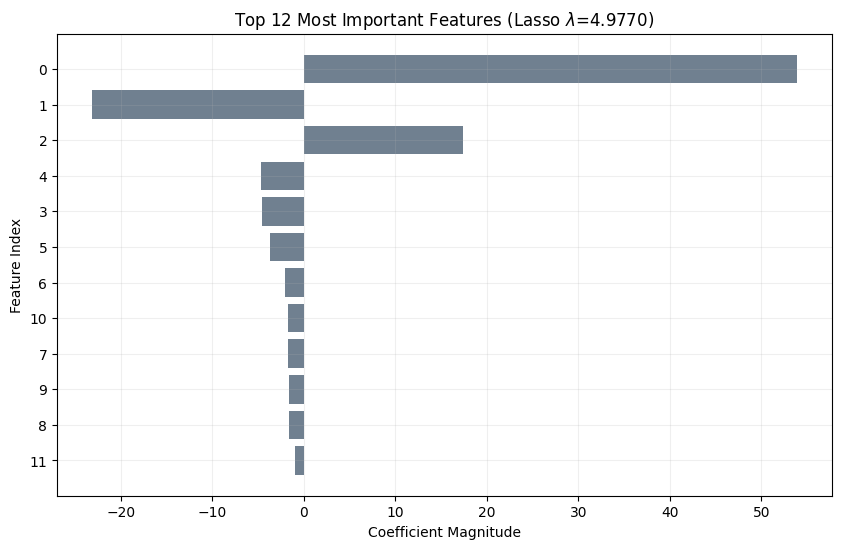

In [53]:
feature_indices = np.arange(X.shape[1])

# Get coefficients and sort by absolute value
sorted_idx = np.argsort(np.abs(lasso_lars_coef))[::-1]
sorted_coefs = lasso_lars_coef[sorted_idx]
sorted_features = feature_indices[sorted_idx]

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.barh(range(sum(lasso_lars_coef != 0)), sorted_coefs[:sum(lasso_lars_coef != 0)], align='center',color='slategray')
plt.yticks(range(sum(lasso_lars_coef != 0)), sorted_features[:sum(lasso_lars_coef != 0)])
plt.title(rf'Top {sum(lasso_lars_coef != 0)} Most Important Features (Lasso $\lambda$={best_lambda_lasso_lars_ose:.4f})')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature Index')
plt.grid(alpha=0.2)
plt.gca().invert_yaxis()  # Highest coefficient at top
plt.show()

As expected, we reach the same conclusion as in the previous section (with the conjgate coordinate descent method). However, LARS implementation is converges faster.

# **Elastic Net Regression** 

In [54]:
from sklearn.linear_model import ElasticNet

In [55]:
# Now we have to train 2 parameters: lambda and the ratio
# Define a range of lambda (alpha) values and l1_ratio values to test
lambda_values = np.logspace(-3, 3, 100)  # Similar range for alpha
l1_ratios = np.linspace(0.05, 0.95, 19)   # Mix ratio between Lasso (L1) and Ridge (L2)

# Define a pipeline that includes normalization and regression to introduce in GridSearchCV
elasticnet_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('elasticnet', ElasticNet(max_iter=20000))  # Apply ElasticNet with a high iteration limit
])

# We need a dictionary as an input for the parameters
param_grid = {
    'elasticnet__alpha': lambda_values,
    'elasticnet__l1_ratio': l1_ratios  # The mix ratio between Lasso and Ridge
}

# Perform GridSearchCV to find the best lambda and l1_ratio
elasticnet_cv = GridSearchCV(estimator=elasticnet_pipeline, param_grid=param_grid,
                             scoring='neg_mean_squared_error', cv=5, n_jobs=-1) # Use all processors
elasticnet_cv.fit(X, y)  # Uses the normalized data established in the pipeline

# TRY TO APPLY ONE STANDARD ERROR RULE HERE

# Get the best parameters
best_lambda = elasticnet_cv.best_params_['elasticnet__alpha']
best_l1_ratio = elasticnet_cv.best_params_['elasticnet__l1_ratio']
print(f"Best lambda for ElasticNet: {best_lambda}")
print(f"Best L1 ratio for ElasticNet: {best_l1_ratio}")

# Fit ElasticNet with the best hyperparameters
best_elasticnet = ElasticNet(alpha=best_lambda, l1_ratio=best_l1_ratio, max_iter=20000)
best_elasticnet.fit(StandardScaler().fit_transform(X), y)  # Transform X before fitting

Best lambda for ElasticNet: 0.13219411484660287
Best L1 ratio for ElasticNet: 0.75


ElasticNet(alpha=np.float64(0.13219411484660287), l1_ratio=np.float64(0.75),
           max_iter=20000)

Makes sense that the best l1_ratio is 0.95, as we have seen that Lasso performs better than Ridge in this data set!!

In [56]:
from sklearn.model_selection import cross_val_score
# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_elasticnet = np.sqrt(-cross_val_score(best_elasticnet, scaler.transform(X), y, scoring='neg_mean_squared_error', cv=5))

# Estimate of RMSE (average over folds)
estimated_RMSE_elasticnet = np.mean(cv_rmse_scores_elasticnet)

print(f"Estimated RMSE for each fold Elastic Net: {cv_rmse_scores_elasticnet}")
print(f"Estimated RMSE (average) Elastic Net: {estimated_RMSE_elasticnet:.4f}")

Estimated RMSE for each fold Elastic Net: [25.17095232 17.63466567 30.21276362 30.78669272 22.97917855]
Estimated RMSE (average) Elastic Net: 25.3569


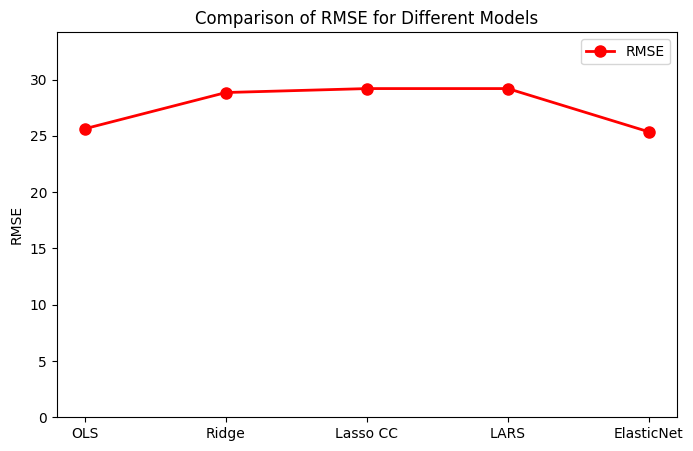

In [57]:
# RMSE values for the five models
models = ['OLS', 'Ridge', 'Lasso CC', 'LARS', 'ElasticNet']
rmse_values = [estimated_RMSE_ols, estimated_RMSE_ridge, estimated_RMSE_lasso, 
               estimated_RMSE_lasso_lars, estimated_RMSE_elasticnet]  # Replace with actual values

# Create the line plot
plt.figure(figsize=(8, 5))
plt.plot(models, rmse_values, marker='o', linestyle='-', color='red', linewidth=2, markersize=8, label='RMSE')

# Labels and title
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Models')
plt.ylim(0, max(rmse_values) + 5)  # Adjust y-axis range for better visualization

# Show plot
plt.legend()
plt.show()
